In [1]:
# Dataset testing

import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import sigpy
import skimage
import os
import multiprocessing as mp
from multiprocessing import Pool
from PIL import Image
import tqdm
import glob

from noncart_training.dataset import *
from dnnlib.util import *
from torch_utils import distributed as dist
from torch_utils import misc
from noncart_training.trajectory import *
import generate_conditional

device = torch.device('cuda')

/home/trevor/miniconda3/envs/edm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def tensor_to_image(images, horv='v'):
    if horv == 'h':
        images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(2, 0, 3, 1).cpu().numpy()
        h,b,w,c = images.shape
        images = images.reshape(h,w*b,c)
    else:
        images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
        h,b,w,c = images.shape
        images = images.reshape(h*b,w,c)
    if images.shape[2] == 3:
        return PIL.Image.fromarray(images, 'RGB')
    else:
        return PIL.Image.fromarray(images[:,:,0], 'L')
    
def image_to_tensor(pil_img):
    tensor_img = torch.tensor(np.array(pil_img))
    if len(tensor_img.shape) == 2:
        tensor_img = ((tensor_img.to(torch.float32) - 128) / 127.5).to(device)
    else:
        assert len(tensor_img.shape) == 3
        tensor_img = ((tensor_img.to(torch.float32) - 128) / 127.5).permute(2, 0, 1).to(device)
    return tensor_img.unsqueeze(0)
    
def image_array(images, columns=4, cmap='gray'):
    fig, axs = plt.subplots(int(len(images)/(columns+.01))+1, columns, figsize=(12,8), frameon=False)
    plt.subplots_adjust(wspace=0, hspace=0)
    if len(images)<=columns:
        for i,img in enumerate(images):
            axs[i].imshow(img, cmap=cmap)
            axs[i].set_axis_off()
    else:
        for i,img in enumerate(images):
            axs[i//columns,i%columns].imshow(img, cmap=cmap)
            axs[i//columns,i%columns].set_axis_off()

In [16]:
# Load dataset.
seeds = [0,]
dataset_kwargs = dnnlib.EasyDict(class_name='noncart_training.dataset.NonCartesianDataset', path='../fastMRIprocessing/data_128_multicoil', use_labels=False, xflip=False, fetch_raw=True, undersampling=0.2)
data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=8, prefetch_factor=2)
dist.print0('Loading dataset...')
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seeds[0])
dataset_iterator = iter(torch.utils.data.DataLoader(dataset=dataset_obj, sampler=dataset_sampler, batch_size=1, **data_loader_kwargs))

Loading dataset...


In [3]:
# Load dataset.
seeds = [0,]
dataset_kwargs = dnnlib.EasyDict(class_name='noncart_training.dataset.NonCartesianDataset', path='../fastMRIprocessing/data_256_multicoil_small', use_labels=False, xflip=False, fetch_raw=True, undersampling=0.2)
data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=8, prefetch_factor=2)
dist.print0('Loading dataset...')
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seeds[0])
dataset_iterator = iter(torch.utils.data.DataLoader(dataset=dataset_obj, sampler=dataset_sampler, batch_size=1, **data_loader_kwargs))

Loading dataset...


In [17]:
parcel = next(dataset_iterator)

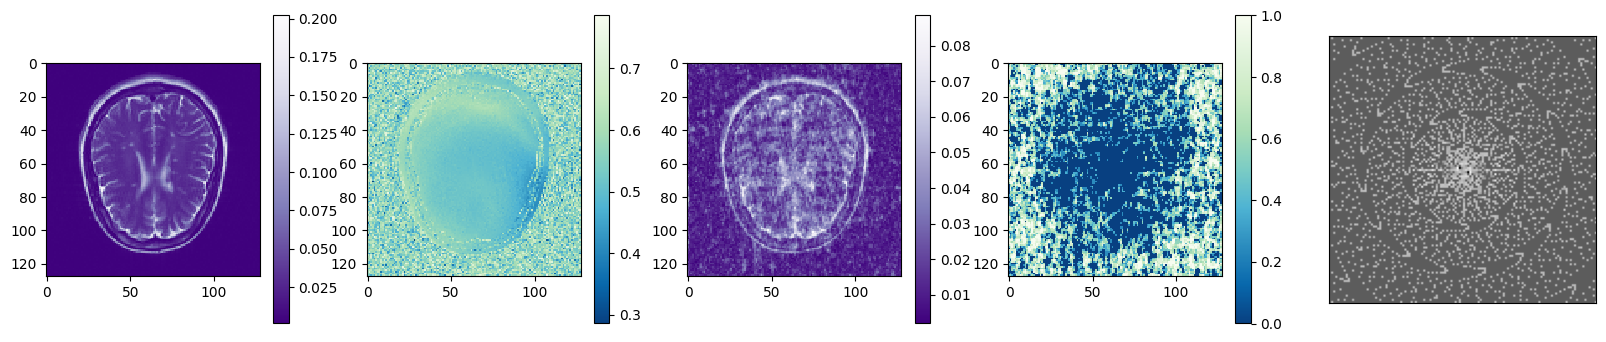

In [18]:
fig, (ax1,ax2,ax3,ax4, ax5) = plt.subplots(figsize=(20, 4), ncols=5)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

pos1 = ax1.imshow(root_summed_squares(parcel[0])[0][0], cmap='Purples_r', interpolation='none')
fig.colorbar(pos1, ax=ax1)

pos2 = ax2.imshow(root_summed_squares(parcel[0])[1][0], cmap='GnBu_r', interpolation='none')
fig.colorbar(pos2, ax=ax2)

pos3 = ax3.imshow(root_summed_squares(parcel[1])[0][0], cmap='Purples_r', interpolation='none')
fig.colorbar(pos3, ax=ax3)

pos4 = ax4.imshow(root_summed_squares(parcel[1])[1][0], cmap='GnBu_r', interpolation='none')
fig.colorbar(pos4, ax=ax4)

masked = torch.clone(parcel[3][0,0,:,:])
masked[masked==0]=torch.amin(masked)/2
pos5 = ax5.imshow(np.fft.fftshift(masked), cmap='gray')

plt.savefig('data_prior.png',dpi=150)

In [19]:
config = {
    'network_pkl': 'model_files/network-snapshot-052550.pkl',
    'class_idx': None,
    'num_steps': 100,
    'sigma_min': 0.002,
    'sigma_max': 80,
    'guidance':  0.05,
}

# config = {
#     'network_pkl': 'model_files/network-snapshot-012500.pkl',
#     'class_idx': None,
#     'num_steps': 100,
#     'sigma_min': 0.002,
#     'sigma_max': 80,
#     'guidance':  0.05,
# }

with dnnlib.util.open_url(config['network_pkl'], verbose=True) as f:
    net = pickle.load(f)['ema'].to(device)

In [20]:

batch = parcel[0].shape[0]
# latents = torch.randn(batch, net.img_channels, net.img_resolution, net.img_resolution).to(device) * config['sigma_max']
latents = torch.randn([1, net.img_channels, net.img_resolution, net.img_resolution], device=device)
priors = parcel[1].to(device)
kspace = parcel[3].to(device)

# Run the reverse ODE
for s in tqdm.tqdm(dnnlib.util.call_func_by_name(net=net, latents=latents, priors=priors, kspace=kspace, class_labels=None, num_steps=config['num_steps'], sigma_min=config['sigma_min'], sigma_max=config['sigma_max'], func_name='generate_conditional.conditional_huen_sampler', S_churn=0, to_yield=True), total=config['num_steps']):
    # if s.step > 50:
    #     break
    pass
image = s.denoised

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.99it/s]


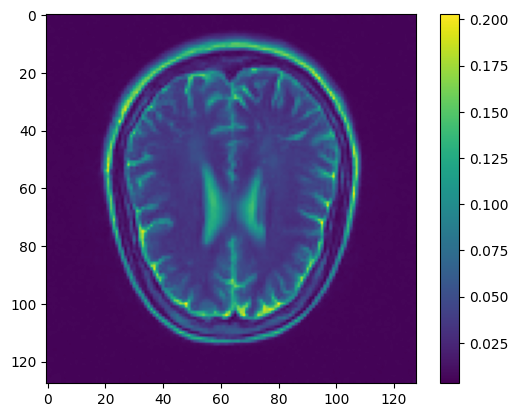

In [21]:
plt.imshow(np.array(root_summed_squares(image)[0][0].cpu()))
plt.colorbar()

In [27]:

batch = parcel[0].shape[0]
# latents = torch.randn(batch, net.img_channels, net.img_resolution, net.img_resolution).to(device) * config['sigma_max']
latents = torch.randn([1, net.img_channels, net.img_resolution, net.img_resolution], device=device)
priors = parcel[1].to(device)
kspace = parcel[3].to(device)

# Run the reverse ODE
for s in tqdm.tqdm(dnnlib.util.call_func_by_name(net=net, latents=latents, priors=priors, kspace=kspace, class_labels=None, num_steps=config['num_steps'], sigma_min=config['sigma_min'], sigma_max=config['sigma_max'], guidance=config['guidance'], func_name='generate_conditional.kspace_gradient_sampler', S_churn=0, to_yield=True), total=config['num_steps']):
    if s.step > 10:
        break
    pass
image = s.denoised
# images_pil = tensor_to_image(images)

 10%|████████████████▌                                                                                                                                                     | 10/100 [00:00<00:04, 18.43it/s]


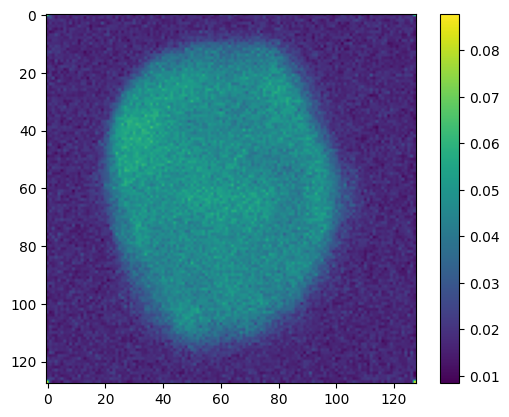

In [28]:
plt.imshow(np.array(root_summed_squares(s.denoised.cpu())[0][0]))
plt.colorbar()

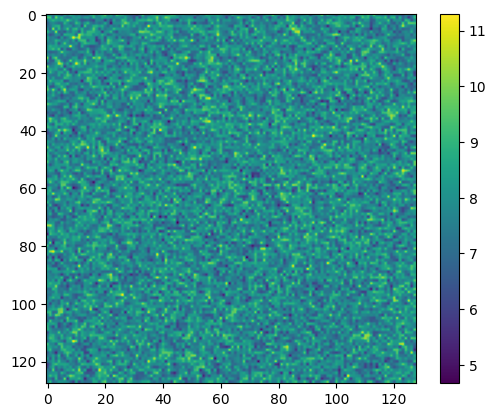

In [29]:
plt.imshow(np.array(root_summed_squares(s.x_gradient.cpu())[0][0]))
plt.colorbar()

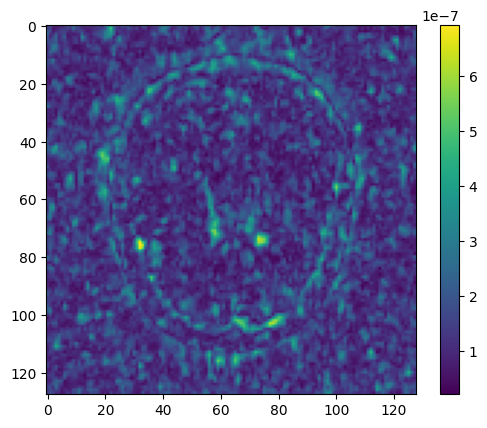

In [23]:

k_complex = parcel[3][0,::2]+parcel[3][0,1::2]*1j
plt.imshow(torch.mean(torch.fft.fftshift(torch.abs(torch.fft.ifft2(k_complex))), dim=0))
plt.colorbar()

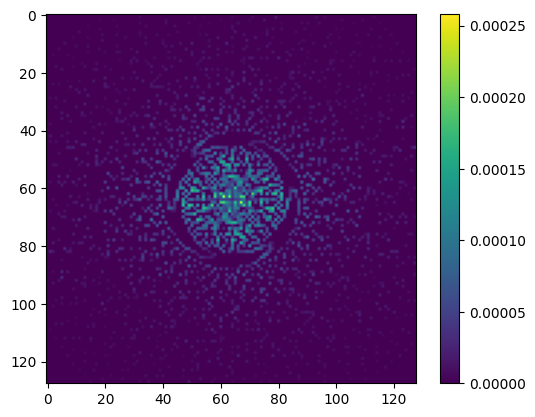

In [24]:
plt.imshow(torch.mean(torch.abs(torch.fft.fftshift(k_complex)), dim=0))
plt.colorbar()

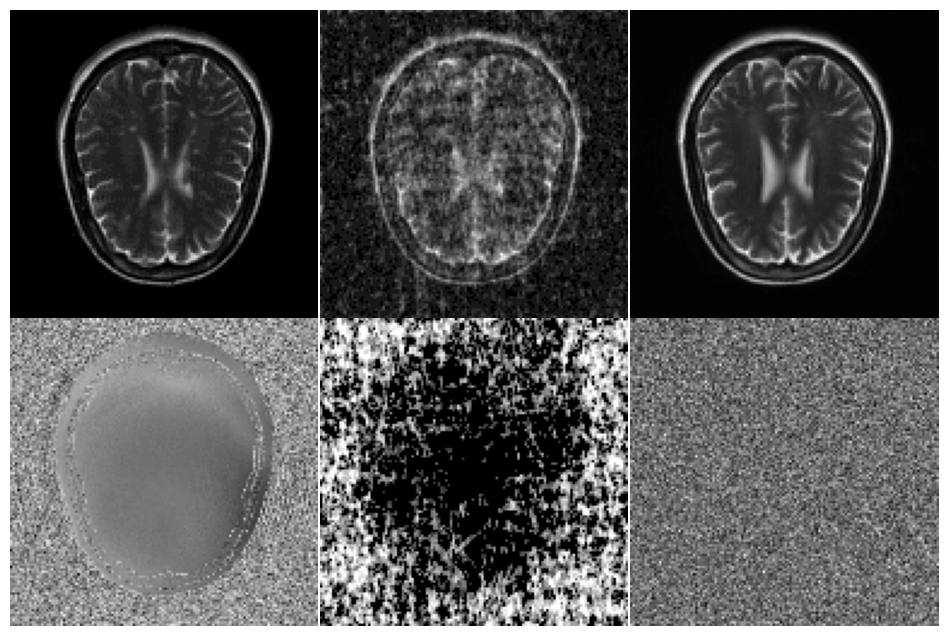

In [22]:
image_array((tensor_to_image(root_summed_squares(parcel[0])[0].unsqueeze(0)),
             tensor_to_image(root_summed_squares(parcel[1])[0].unsqueeze(0)),
             tensor_to_image(root_summed_squares(image)[0].unsqueeze(0)*4),
             tensor_to_image(root_summed_squares(parcel[0])[1].unsqueeze(0)),
             tensor_to_image(root_summed_squares(parcel[1])[1].unsqueeze(0)),
             tensor_to_image(root_summed_squares(image)[1].unsqueeze(0)),)
             , 3)
